# SWMAL-01 O4

#### Group number: SWMAL_Grp 01

#### Group members:

| Name             | Student Number |
| ---------------- | -------------- |
| Kristian Lund | 201205937      |
| Jeppe Pape | xxx      |
| Niels Kristensen | xxx      |


## Global imports

In [1]:
import numpy as np
from FEN_to_64grid import FEN_to_seq #Our Method
from FEN_to_64grid import seq_to_FEN #Our Method

from PIL import Image #For Saving images as files
import os #For file path
from os import listdir #For file path
import matplotlib.image as mpimg #For plotting
import matplotlib.pyplot as plt #For plotting
from sklearn.model_selection import train_test_split#For train and test split
from enum import Enum # For Enum class
from keras.utils import to_categorical #For enum labels
import keras
from keras import layers
from sklearn import metrics #For Confusion Matrix

### Splitting chessboard images into single board positions

In [4]:
#Load data into individual position images
# This method also removes duplicates
def Save_individual_positions(data_path, destination_path):
        for file in os.listdir(data_path):
                #Get FEN from file
                FEN_string = file.replace('.jpeg', '')
                #Convert to seq name
                chessboard_seq = FEN_to_seq(FEN_string)
                #Go through all jpeg images
                if (file.endswith(".jpeg")):
                        # Store file as image data
                        file_path = os.path.join(data_path, file)
                        image = mpimg.imread(file_path)
                        #For all positions
                        for i in range(1,65):
                                #Make file name
                                if (chessboard_seq[i-1] != "_"):
                                        new_file_name = os.path.join(chessboard_seq[i-1]+str(i)+"/", chessboard_seq,'.jpeg')
                                else:
                                        new_file_name = os.path.join(chessboard_seq[i-1]+"_", chessboard_seq,'.jpeg')
                                new_file_name = new_file_name.replace('\\','')
                                #Save image
                                zoom_image = zoom_to_position(image,i)
                                new_image = Image.fromarray(zoom_image.astype('uint8'))
                                new_image.save(os.path.join(destination_path, new_file_name))

### Loading the data

To load data from a folder a function `Import_individual_positions(data_path)` was made. Here each 50x50 image is loaded into the X matrix and the label corresponds to the first element in the name of each file.

In [5]:
#Load data into individual position images
def Import_individual_positions(data_path):
        X = []
        y = []
        for file in os.listdir(data_path):
                #Go through all jpeg images
                if (file.endswith(".jpeg")):
                        # Store file as image data
                        file_path = os.path.join(data_path, file)
                        image = mpimg.imread(file_path)
                        #store image in X
                        X.append(image)
                        #store label
                        y.append(file[0])
        return X, y

From this the X_raw (data matrix) and y_raw (vector containing data labels) can be defined.

In [6]:
data_path = r'train_individual_pos' #Set data folder
X_raw, y_raw = Import_individual_positions(data_path)

In [7]:
class CharEnum(Enum):
    _ = 0
    P = 1
    N = 2
    B = 3
    R = 4
    Q = 5
    K = 6
    p = 7
    n = 8
    b = 9
    r = 10
    q = 11
    k = 12

In [8]:
#Convert to numpy array
X = np.array(X_raw)
y_num = [CharEnum[char].value for char in y_raw] #Convert ASCII to numbers from 1-13
y = np.array(y_num)

#Preprocess
X = X.reshape(-1, 50, 50, 3).astype('uint8') / 255 #RGB pixels from 0-255
y = to_categorical(y, num_classes=None) #Convert int to binary class matrix (One-hot)

## Valg af ML algoritme

#### Build model

In [9]:
import keras
from keras import layers

In [10]:
#13 pieces (6*2 types + blank space)
from keras.regularizers import l2
from keras.layers import Dropout

#Advanced
def make_advanced_model():
    advanced_model = keras.Sequential()
    advanced_model.add(layers.Conv2D(filters = 6, kernel_size=(2, 2), activation='relu', input_shape=(50,50,3))) #Input layer
    advanced_model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Downsampling layer
    advanced_model.add(layers.Conv2D(filters = 16, kernel_size=(2, 2), activation='relu'))
    advanced_model.add(layers.AveragePooling2D(pool_size=(2, 2)))

    advanced_model.add(layers.Flatten()) #Flatten layer

    # Assuming advanced_model is defined as Sequential or Functional API
    advanced_model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Add L2 regularization
    advanced_model.add(Dropout(0.5))  # Add Dropout layer
    advanced_model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    advanced_model.add(Dropout(0.5))
    advanced_model.add(layers.Dense((13), activation='softmax'))  # Output layer

    return advanced_model

advanced_model = make_advanced_model()
advanced_model.summary()

c:\Users\jeppe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 49, 49, 6)      │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 16)     │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 11, 11, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,515 (1005.92 KB)

 Trainable params: 257,515 (1005.92 KB)

 Non-trainable params: 0 (0.00 B)

#### Test/Train split + shuffle

In [11]:
X_train = X
y_train = y

In [14]:
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Shuffle X_train and y_train
X_train, y_train = shuffle(X_train, y_train, random_state=42)  # Random state for reproducibility


datagen = ImageDataGenerator(validation_split=0.2)
train_generator = datagen.flow(X_train, y_train, batch_size=32, subset='training')
validation_generator = datagen.flow(X_train, y_train, batch_size=32, subset='validation')

In [15]:
#Compile
advanced_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Train
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',             # Monitor validation loss
    patience=5,                     # Stop if no improvement after 5 epochs
    restore_best_weights=True       # Restore the best weights at the end
)

history = advanced_model.fit(
    train_generator,
    epochs=50,                      # Increase epochs if using EarlyStopping
    validation_data=validation_generator,
    callbacks=[early_stopping]      # Add callback
)

#Save
advanced_model.save('advnced_model.keras')

Epoch 1/50


c:\Users\jeppe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22011/22011 ━━━━━━━━━━━━━━━━━━━━ 384s 17ms/step - accuracy: 0.8753 - loss: 0.6210 - val_accuracy: 0.9997 - val_loss: 0.1327
Epoch 2/50
22011/22011 ━━━━━━━━━━━━━━━━━━━━ 158s 7ms/step - accuracy: 0.9688 - loss: 0.2238 - val_accuracy: 0.9998 - val_loss: 0.1222
Epoch 3/50
22011/22011 ━━━━━━━━━━━━━━━━━━━━ 134s 6ms/step - accuracy: 0.9732 - loss: 0.2004 - val_accuracy: 0.9996 - val_loss: 0.1216
Epoch 4/50
22011/22011 ━━━━━━━━━━━━━━━━━━━━ 121s 6ms/step - accuracy: 0.9748 - loss: 0.1934 - val_accuracy: 0.9999 - val_loss: 0.1165
Epoch 5/50
22011/22011 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - accuracy: 0.9755 - loss: 0.1917 - val_accuracy: 0.9992 - val_loss: 0.1187
Epoch 6/50
22011/22011 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - accuracy: 0.9755 - loss: 0.1897 - val_accuracy: 0.9997 - val_loss: 0.1088
Epoch 7/50
22011/22011 ━━━━━━━━━━━━━━━━━━━━ 132s 6ms/step - accuracy: 0.9761 - loss: 0.1877 - val_accuracy: 0.9999 - val_loss: 0.1184
Epoch 8/50
22011/22011 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - accuracy: 0.

Text(0.5, 0, 'Epochs')

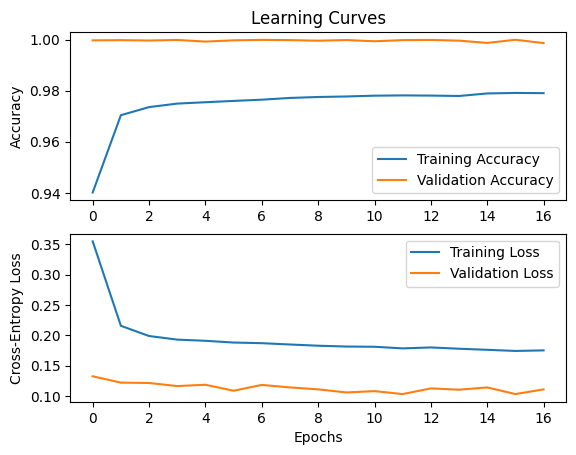

In [16]:
#Plot figure of epoch history

# Save the training history
history_dict = history.history

fig, axs = plt.subplots(2)

axs[0].plot(history_dict['accuracy'], label='Training Accuracy')
axs[0].plot(history_dict['val_accuracy'], label='Validation Accuracy')
axs[0].legend()
axs[0].set_title('Learning Curves')
axs[0].set_ylabel('Accuracy')
axs[1].plot(history_dict['loss'], label='Training Loss')
axs[1].plot(history_dict['val_loss'], label='Validation Loss')
axs[1].legend()
axs[1].set_ylabel('Cross-Entropy Loss')
plt.xlabel('Epochs')

#### Predict

In [17]:
data_path = r'test_individual_pos' #Set data folder
X_original, y_original = Import_individual_positions(data_path)

In [18]:
#Convert to numpy array
X_ = np.array(X_original)
y_num = [CharEnum[char].value for char in y_original] #Convert ASCII to numbers from 1-13
y_ = np.array(y_num)

#Preprocess
X_test = X_.reshape(-1, 50, 50, 3).astype('uint8') / 255 #RGB pixels from 0-255
y_test = to_categorical(y_, num_classes=None) #Convert int to binary class matrix (One-hot)

In [19]:
y_pred = advanced_model.predict(X_test)
print(y_pred.shape)

6865/6865 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
(219656, 13)


This is a b with 99.9% certainty
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


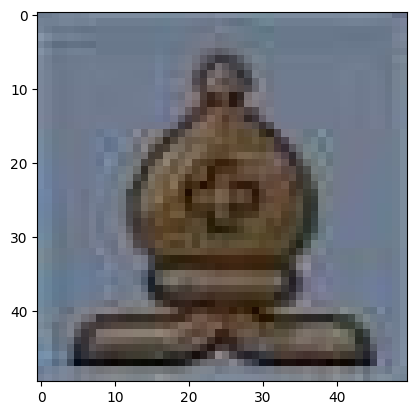

In [20]:
#Predict a single element
data_indice = 5

prediction_1 = y_pred[data_indice]
max_value = np.max(prediction_1)
max_arg = np.argmax(prediction_1)

#From number to symbol
print(f"This is a {CharEnum(max_arg).name} with {100*max_value:.1f}% certainty")

#Print correct answer
print(y_test[data_indice])

# Print image
plt.imshow(X_test[data_indice])

#### Calculate accuracy and loss from whole test set

In [21]:
loss_from_test, acc_from_test = advanced_model.evaluate(X_test, y_test)
print(f"Loss: {loss_from_test}")
print(f"Accuracy: {acc_from_test}")

6865/6865 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9999 - loss: 0.1027
Loss: 0.1031448021531105
Accuracy: 0.999854326248169


#### Confusion matrix

In [25]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [26]:
print(y_test[0])
print(y_true[0])
print(y_pred[0])
print(y_pred_classes[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
9
[0.0000000e+00 3.1602645e-15 1.1380344e-12 1.9798449e-03 3.1324096e-10
 2.9960720e-10 1.6879309e-13 1.7098922e-19 1.2304876e-12 9.9802017e-01
 1.5345991e-10 4.7720665e-13 1.6867673e-15]
9


In [27]:
print(y_pred_classes)
print(y_true_classes)

[9 3 3 ... 0 0 0]
[9 3 3 ... 0 0 0]


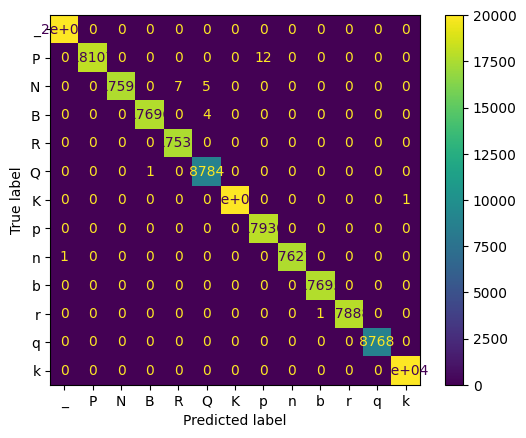

In [28]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true_classes, y_pred_classes)
class_names = [char.name for char in CharEnum]
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
cm_display.plot()
plt.show()